In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.stats import gaussian_kde
from PIL import Image
import time

In [2]:
def conv_time(ms):
    ms = datetime.datetime.fromtimestamp(ms)
    return ms

In [ ]:
fixations = pd.read_csv('./simone/oasis_mark/fixations.csv')

In [ ]:
events = pd.read_csv('./simone/oasis_raw/raw/events.csv')

In [ ]:
events

In [ ]:
imu = pd.read_csv('./simone/oasis_raw/raw/imu.csv')

In [ ]:
imu

In [ ]:
start = np.array(events['timestamp [ns]'].loc[(events['name']=='recording.begin')])[0]
end = np.array(events['timestamp [ns]'].loc[(events['name']=='recording.end')])[0]

In [ ]:
fix =  fixations.loc[(fixations['fixation detected on surface'] == True)]

In [ ]:
fix = fix.loc[(fix['start timestamp [ns]']>=start) & (fix['end timestamp [ns]']<=end)]

In [ ]:
fix

In [ ]:
fix_x = fix['fixation x [normalized]']
fix_y = fix['fixation y [normalized]']

In [ ]:
plt.scatter(fix_x,fix_y)
plt.xlim(fix_x.min(),fix_x.max())
plt.ylim(fix_y.min(),fix_y.max())
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
scale = 1000
fix_x *= scale
fix_y *= scale

In [ ]:
fix_y = (fix_y-scale)*-1

In [ ]:
background = np.array(Image.open('./simone/heatmap/overlay.jpeg'))

In [ ]:
plt.imshow(background)

In [ ]:
kde = gaussian_kde([fix_x, fix_y])
x_grid, y_grid = np.mgrid[0:scale:scale*1j, 0:scale:scale*1j]
z = kde(np.vstack([x_grid.ravel(), y_grid.ravel()]))
plt.figure(figsize=(8, 4))
plt.contourf(x_grid, y_grid, z.reshape(x_grid.shape), cmap='Reds', alpha=0.7)
plt.colorbar()
plt.scatter(fix_x,fix_y, alpha=0.4)
#plt.imshow(np.rot90(background,k=2))
plt.xlim(0,scale)
plt.ylim(0,scale)
plt.savefig('./cloud.pdf')

In [ ]:
int(fix_x.min()*scale)

In [ ]:
plt.scatter(fix_x.mean(),fix_y.mean())
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
import skimage
import av

In [ ]:
v = av.open('eyes.mp4')

In [ ]:
frames_r = []
frames_l = []
frames = []
for frame in v.decode(video=0):
    # Decode video frame, and convert to NumPy array in BGR pixel format (use BGR because it used by OpenCV).
    frame = frame.to_ndarray(format='gray')  # For Grayscale video, use: frame = frame.to_ndarray(format='gray')
    frames.append(frame)
    lenght = int(frame.shape[1]/2)
    #frame = frame[:,:,0]
    frame_r = frame[:,0:lenght]
    frame_l = frame[:,lenght:]
    frames_r.append(frame_r)
    frames_l.append(frame_l)

In [ ]:
len(frames_r),len(frames_l)

In [ ]:
frame_r = frames_r[np.random.randint(0,len(frames_r))]

In [ ]:
frame_x = frames[np.random.randint(0,len(frames))]
plt.imshow(frame_x,cmap='plasma')

In [ ]:
frame_r.shape

In [ ]:
frame_r = skimage.transform.rescale(frame_r, 0.5, anti_aliasing=False)
print(frame_r.shape)

In [ ]:
plt.imshow(frame_r)

In [ ]:
threshold = skimage.filters.threshold_multiotsu(frame_r, classes=5)
threshold
image_mask = frame_r < threshold[0]
#plt.imshow(image_mask, cmap='gray')
labels = skimage.measure.label(image_mask * 1)
props = skimage.measure.regionprops_table(labels, properties=('centroid',
                                                              'orientation',
                                                              'axis_major_length',
                                                              'axis_minor_length', 'bbox', 'image', 'label',
                                                              'area_bbox', 'area', 'eccentricity'))

props = pd.DataFrame(props)
props
props = props.loc[
    (props['axis_minor_length'] > 0) & (props['axis_major_length'] > 0) & (props['area'] > 100) & (props['area'] < 800)].sort_values(
    'eccentricity')
props
xmin = props['bbox-0'].iat[0]
xmax = props['bbox-2'].iat[0]
ymin = props['bbox-1'].iat[0]
ymax = props['bbox-3'].iat[0]
pupil = frame_r[xmin:xmax, ymin:ymax]
plt.imshow(pupil, cmap='gray')
diameter = props['axis_major_length'].iat[0]

In [ ]:
import time

In [ ]:
time.time_ns()

In [ ]:
def pupil_detection(frame):
    # provare con immagini a 4 bit
    # escludere la  o fondere le due immagini
    # gaussian blur + apertura chiusura per rumore
    # scalare valori px in base a dimensione immagine
    # rescaling luminosità + multiostu classes sulla base della luminosità
    t1 = time.time_ns()
    try:
        threshold = skimage.filters.threshold_multiotsu(frame, classes=5)
        threshold
        image_mask = frame < threshold[0]
        #plt.imshow(image_mask, cmap='gray')
        labels = skimage.measure.label(image_mask * 1)
        props = skimage.measure.regionprops_table(labels, properties=('centroid',
                                                                      'orientation','axis_major_length','axis_minor_length', 'bbox', 'image', 'label',
                                                                      'area_bbox', 'area', 'eccentricity'))

        props = pd.DataFrame(props)
        props
        props = props.loc[
            (props['axis_minor_length'] > 0) & (props['axis_major_length'] > 0) & (props['area'] > 150) & (props['area'] < 800)].sort_values(
            'eccentricity')
        props
        xmin = props['bbox-0'].iat[0]
        xmax = props['bbox-2'].iat[0]
        ymin = props['bbox-1'].iat[0]
        ymax = props['bbox-3'].iat[0]
        pupil = frame[xmin:xmax, ymin:ymax]
        plt.imshow(pupil, cmap='gray')
        diameter = props['axis_major_length'].iat[0]
    except:
        diameter = 0
    t2 = time.time_ns()
    duration = np.round((t2-t1)*10**(-9),decimals=3)

    return diameter,duration

In [ ]:
pupil_detection(frame_r)

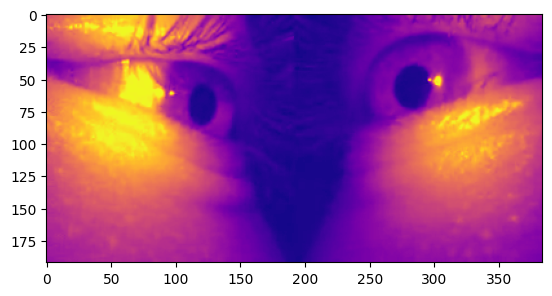

In [149]:
frame_x = frames[np.random.randint(0,len(frames))]
plt.imshow(frame_x,cmap='plasma')

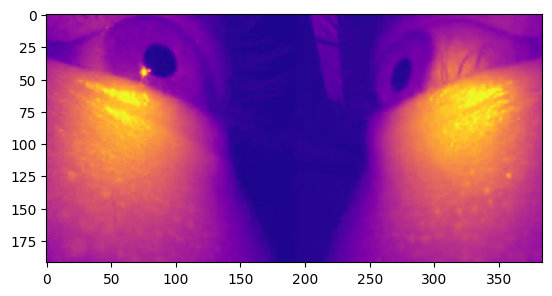

In [159]:
frame_x = frames[np.random.randint(0, len(frames))]
plt.imshow(frame_x, cmap='plasma')

def multi_pupil_detection(frame):
    # provare con immagini a 4 bit
    # escludere la  o fondere le due immagini
    # gaussian blur + apertura chiusura per rumore
    # scalare valori px in base a dimensione immagine
    # rescaling luminosità + multiostu classes sulla base della luminosità
    t1 = time.time_ns()
    lenght = int(frame.shape[1]/2)
    #frame = frame[:,:,0]
    threshold = skimage.filters.threshold_multiotsu(frame, classes=5)
    frame_r = frame[:,lenght:]
    try:
        #threshold = skimage.filters.threshold_multiotsu(frame_r, classes=5)
        image_mask = frame_r < threshold[0]
        image_mask = image_mask * 1
        #plt.imshow(image_mask, cmap='gray')
        labels_r = skimage.measure.label(image_mask)
        props = skimage.measure.regionprops_table(labels_r, properties=('centroid',
                                                                      'orientation','axis_major_length','axis_minor_length', 'bbox', 'image', 'label',
                                                                      'area_bbox', 'area', 'eccentricity'))

        props = pd.DataFrame(props)
        props = props.loc[
            (props['axis_minor_length'] > 0) & (props['axis_major_length'] > 0) & (props['area'] > 50) & (props['area'] < 1000)].sort_values(
            'eccentricity')
        eccentricity_r = props['eccentricity'].iat[0]
        xmin_r = props['bbox-0'].iat[0]
        xmax_r = props['bbox-2'].iat[0]
        ymin_r = props['bbox-1'].iat[0]
        ymax_r = props['bbox-3'].iat[0]
        pupil_r = frame_r[xmin_r:xmax_r, ymin_r:ymax_r]
        canny_r = skimage.feature.canny(pupil_r)
        diameter_r = props['axis_major_length'].iat[0]
    except:
        diameter_r = 0
        eccentricity_r = 1

    frame_l = frame[:,0:lenght]
    try:
        #threshold = skimage.filters.threshold_multiotsu(frame_l, classes=5)
        image_mask = frame_l < threshold[0]
        image_mask = image_mask * 1
        #plt.imshow(image_mask, cmap='gray')
        labels_l = skimage.measure.label(image_mask)
        props = skimage.measure.regionprops_table(labels_l, properties=('centroid',
                                                                      'orientation','axis_major_length','axis_minor_length', 'bbox', 'image', 'label',
                                                                      'area_bbox', 'area', 'eccentricity'))

        props = pd.DataFrame(props)
        props = props.loc[
            (props['axis_minor_length'] > 0) & (props['axis_major_length'] > 0) & (props['area'] > 50) & (props['area'] < 1000)].sort_values(
            'eccentricity')
        eccentricity_l = props['eccentricity'].iat[0]
        xmin_l = props['bbox-0'].iat[0]
        xmax_l = props['bbox-2'].iat[0]
        ymin_l = props['bbox-1'].iat[0]
        ymax_l = props['bbox-3'].iat[0]
        pupil_l = frame_l[xmin_l:xmax_l, ymin_l:ymax_l]
        canny_l = skimage.feature.canny(pupil_l)
        diameter_l = props['axis_major_length'].iat[0]
    except:
        diameter_l = 0
        eccentricity_l = 1

    diameter = max(diameter_l,diameter_r)
    #if (diameter_r>diameter_l) and (eccentricity_r<eccentricity_l):
    if (eccentricity_r<eccentricity_l):
        choose = 'right'
        pupil = pupil_r
    #elif (diameter_r<diameter_l) and (eccentricity_r>eccentricity_l):
    elif (eccentricity_r>eccentricity_l):
        choose = 'left'
        pupil = pupil_l
    elif diameter_r==diameter_l:
        choose = 'equal'
        #pupil = (pupil_r,pupil_r)
    else:
        choose = 'error'

    t2 = time.time_ns()
    duration = np.round((t2-t1)*10**(-9),decimals=3)
    #plt.imshow(frame)
    plt.imshow(pupil)

    return diameter,duration,diameter_l,diameter_r,choose
    #return pupil

(28.24444531935307, 2.431, 28.24444531935307, 27.347111123269904, 'left')

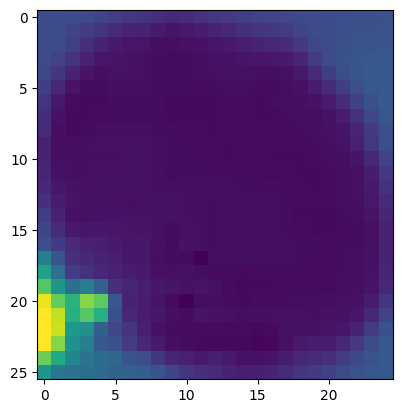

In [160]:
multi_pupil_detection(frame_x)

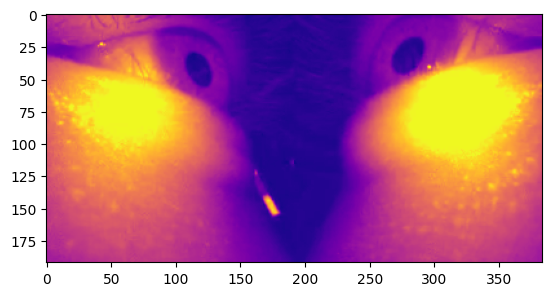

In [207]:
frame_x = frames[np.random.randint(0, len(frames))]
plt.imshow(frame_x, cmap='plasma')

def fast_multi_pupil_detection(frame):
    # provare con immagini a 4 bit
    # escludere la  o fondere le due immagini
    # gaussian blur + apertura chiusura per rumore
    # scalare valori px in base a dimensione immagine
    # rescaling luminosità + multiostu classes sulla base della luminosità
    t1 = time.time_ns()
    lenght = int(frame.shape[1]/2)
    #frame = frame[:,:,0]
    threshold = skimage.filters.threshold_otsu(frame)
    frame[frame>threshold] = 256
    threshold = skimage.filters.threshold_otsu(frame)
    frame_r = frame[:,lenght:]
    try:
        #threshold = skimage.filters.threshold_multiotsu(frame_r, classes=5)
        image_mask = frame_r < threshold
        image_mask = image_mask * 1
        #plt.imshow(image_mask, cmap='gray')
        labels_r = skimage.measure.label(image_mask)
        props = skimage.measure.regionprops_table(labels_r, properties=('centroid',
                                                                        'orientation','axis_major_length','axis_minor_length', 'bbox', 'image', 'label',
                                                                        'area_bbox', 'area', 'eccentricity'))

        props = pd.DataFrame(props)
        props = props.loc[
            (props['axis_minor_length'] > 0) & (props['axis_major_length'] > 10) & (props['area'] > 100) & (props['area'] < 1000)].sort_values(
            'eccentricity')
        eccentricity_r = props['eccentricity'].iat[0]
        xmin_r = props['bbox-0'].iat[0]
        xmax_r = props['bbox-2'].iat[0]
        ymin_r = props['bbox-1'].iat[0]
        ymax_r = props['bbox-3'].iat[0]
        pupil_r = frame_r[xmin_r:xmax_r, ymin_r:ymax_r]
        canny_r = skimage.feature.canny(pupil_r)
        diameter_r = props['axis_major_length'].iat[0]
    except:
        diameter_r = 0
        eccentricity_r = 1

    frame_l = frame[:,0:lenght]
    try:
        #threshold = skimage.filters.threshold_multiotsu(frame_l, classes=5)
        image_mask = frame_l < threshold
        image_mask = image_mask * 1
        #plt.imshow(image_mask, cmap='gray')
        labels_l = skimage.measure.label(image_mask)
        props = skimage.measure.regionprops_table(labels_l, properties=('centroid',
                                                                        'orientation','axis_major_length','axis_minor_length', 'bbox', 'image', 'label',
                                                                        'area_bbox', 'area', 'eccentricity'))

        props = pd.DataFrame(props)
        props = props.loc[
            (props['axis_minor_length'] > 0) & (props['axis_major_length'] > 10) & (props['area'] > 100) & (props['area'] < 1000)].sort_values(
            'eccentricity')
        eccentricity_l = props['eccentricity'].iat[0]
        xmin_l = props['bbox-0'].iat[0]
        xmax_l = props['bbox-2'].iat[0]
        ymin_l = props['bbox-1'].iat[0]
        ymax_l = props['bbox-3'].iat[0]
        pupil_l = frame_l[xmin_l:xmax_l, ymin_l:ymax_l]
        canny_l = skimage.feature.canny(pupil_l)
        diameter_l = props['axis_major_length'].iat[0]
    except:
        diameter_l = 0
        eccentricity_l = 1
    print(diameter_l,diameter_r)
    diameter = max(diameter_l,diameter_r)
    #if (diameter_r>diameter_l) and (eccentricity_r<eccentricity_l):
    if (eccentricity_r<eccentricity_l):
        choose = 'right'
        pupil = pupil_r
    #elif (diameter_r<diameter_l) and (eccentricity_r>eccentricity_l):
    elif (eccentricity_r>eccentricity_l):
        choose = 'left'
        pupil = pupil_l
    elif diameter_r==diameter_l:
        choose = 'equal'
        #pupil = (pupil_r,pupil_r)
    else:
        choose = 'error'

    t2 = time.time_ns()
    duration = np.round((t2-t1)*10**(-9),decimals=3)
    #plt.imshow(frame)
    plt.imshow(pupil)

    return diameter,duration,diameter_l,diameter_r,choose
    #return frame

29.86668842985977 32.167135369815625


/var/folders/0x/mpjl2rfj4l179wzbh88psjd00000gn/T/ipykernel_27442/4208538945.py:14: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  frame[frame>threshold] = 256


(32.167135369815625, 0.012, 29.86668842985977, 32.167135369815625, 'right')

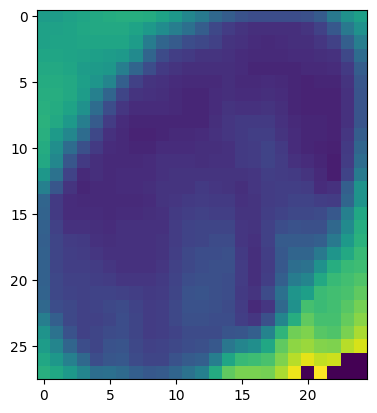

In [208]:
fast_multi_pupil_detection(frame_x)

In [174]:
diameter_l,diameter_r = 20.49129050892141, 35.84257689703117
print(diameter_l,diameter_r)
diameter = max(diameter_l,diameter_r)

20.49129050892141 35.84257689703117


In [ ]:
plt.imshow(frame_x)

In [ ]:
pupil_2 = skimage.morphology.erosion(pupil,skimage.morphology.square(3))
pupil_2 = skimage.morphology.erosion(pupil_2,skimage.morphology.square(3))
pupil_2 = skimage.morphology.erosion(pupil_2,skimage.morphology.square(3))
pupil_2 = skimage.morphology.dilation(pupil_2,skimage.morphology.square(3))
plt.imshow(pupil_2)

In [ ]:
plt.imshow(frame_x)

In [ ]:
square = skimage.morphology.square(3)
square

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

hough_radii = np.arange(diameter)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=pupil.shape)
    pupil[circy, circx] = 1

ax.imshow(pupil, cmap=plt.cm.gray)
plt.show()

In [ ]:
contours

In [ ]:
plt.imshow(contours)

In [ ]:
edges = skimage.feature.canny(pupil)

# Crea un'immagine vuota delle stesse dimensioni dell'immagine di base
output_image = np.copy(pupil)

# Imposta il colore dei bordi
line_color = 1  # Colore delle linee (rosso)

# Sovrapponi l'immagine originale e i bordi trovati con il filtro Canny
output_image[edges] = line_color

# Visualizza l'immagine sovrapposta
plt.imshow(output_image)
plt.show()

In [ ]:
plt.imshow(canny*1)
plt.imshow(pupil)

In [ ]:
plt.imshow(frame_x)
plt.imshow(canny)

In [ ]:
from parfor import pmap

In [ ]:
diameter_list = pmap(pupil_detection,frames_r)

In [ ]:
plt.plot(diameter_list)

In [ ]:
plt.imshow(image_mask)

In [ ]:
x_range = xmax-xmin
y_range = ymax-ymin
pupil_large = frame_r[xmin-int(x_range*0.3):xmax+int(x_range*0.3), ymin-int(y_range*0.3):ymax+int(y_range*0.3)]
canny = skimage.feature.canny(pupil_large)

In [ ]:
plt.imshow(canny*1,cmap='gray')

In [ ]:
from skimage import data, color, img_as_ubyte

result = skimage.transform.hough_ellipse(canny)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = (int(round(x)) for x in best[1:5])
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = skimage.draw.ellipse_perimeter(yc, xc, a, b, orientation)
pupil_large[cy, cx] = 1
# Draw the edge (white) and the resulting ellipse (red)
canny = color.gray2rgb(img_as_ubyte(edges))
canny[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(pupil_large)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(canny)

plt.show()

In [ ]:
result

In [ ]:
hough_radii = np.arange(20,35,1)
hough_res = skimage.transform.hough_circle(canny,hough_radii)

In [ ]:
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(pupil_large)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=pupil_large.shape)
    pupil_large[circy, circx] = 1

ax.imshow(pupil_large, cmap=plt.cm.gray)
plt.show()

In [ ]:
threshold = skimage.filters.threshold_multiotsu(frame_r,classes=5)

In [ ]:
threshold

In [ ]:
image_mask = frame_r < threshold[0]

In [ ]:
plt.imshow(image_mask,cmap='gray')

In [ ]:
labels = skimage.measure.label(image_mask*1)

In [ ]:
props = skimage.measure.regionprops_table(labels, properties=('centroid',
                                                              'orientation',
                                                              'axis_major_length',
                                                              'axis_minor_length','bbox','image','label','area_bbox','area','eccentricity'))


In [ ]:
props = pd.DataFrame(props)

In [ ]:
props

In [ ]:
props = props.loc[(props['axis_minor_length']>0) & (props['axis_major_length']>0) & (props['area']>200)].sort_values('eccentricity')

In [ ]:
props

In [ ]:
xmin = props['bbox-0'].iat[0]
xmax = props['bbox-2'].iat[0]
ymin = props['bbox-1'].iat[0]
ymax = props['bbox-3'].iat[0]

In [ ]:
pupil = frame_r[xmin:xmax,ymin:ymax]

In [ ]:
plt.imshow(pupil,cmap='gray')

In [ ]:
diameter = props['axis_major_length'].iat[0]

In [ ]:
time_series_r = list()
for frame_r in frames_r:
    #plt.imshow(frame_r, cmap='gray')
    threshold = skimage.filters.threshold_multiotsu(frame_r, classes=5)
    threshold
    image_mask = frame_r < threshold[0]
    #plt.imshow(image_mask, cmap='gray')
    labels = skimage.measure.label(image_mask * 1)
    props = skimage.measure.regionprops_table(labels, properties=('centroid',
                                                                  'orientation',
                                                                  'axis_major_length',
                                                                  'axis_minor_length', 'bbox', 'image', 'label',
                                                                  'area_bbox', 'area', 'eccentricity'))

    props = pd.DataFrame(props)
    props
    props = props.loc[
        (props['axis_minor_length'] > 0) & (props['axis_major_length'] > 0) & (props['area'] > 200)].sort_values(
        'eccentricity')
    props
    xmin = props['bbox-0'].iat[0]
    xmax = props['bbox-2'].iat[0]
    ymin = props['bbox-1'].iat[0]
    ymax = props['bbox-3'].iat[0]
    pupil = frame_r[xmin:xmax, ymin:ymax]
    #plt.imshow(pupil, cmap='gray')
    diameter = props['axis_major_length'].iat[0]
    time_series_r.append(diameter)

In [ ]:
plt.plot(time_series_r)

In [ ]:
img_exposed = skimage.exposure.rescale_intensity(frame_r,in_range=(threshold[0],threshold[-1]))

In [ ]:
plt.imshow(img_exposed)

In [ ]:
image_mask = (frame_r < threshold[0])*1

In [ ]:
frame_r[~image_mask] = 0

In [ ]:
label_bg = skimage.measure.label(image_mask,background=True)

In [ ]:
plt.imshow(label_bg)

In [ ]:
label_gb_table = skimage.measure.regionprops_table(label_bg, properties=('centroid',
                                                                         'orientation',
                                                                         'axis_major_length',
                                                                         'axis_minor_length','bbox','image','label','area_bbox','area','eccentricity'))
label_gb_dataframe = pd.DataFrame(label_gb_table)
label_gb_dataframe = label_gb_dataframe.sort_values('eccentricity')

In [ ]:
label_gb_dataframe

In [ ]:
image_mask = label_bg

In [ ]:
canny = skimage.feature.canny(frame_r)

In [ ]:
plt.imshow(canny)

In [ ]:
threshold = canny

In [ ]:
threshold

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
edges = canny(frame_r)#, sigma=3, low_threshold=10, high_threshold=50)


# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(frame_r)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=frame_r.shape)
    frame_r[circy, circx] = 1

ax.imshow(frame_r, cmap=plt.cm.gray)
plt.show()

In [ ]:
plt.imshow(edges)

In [ ]:
image.shape